In [1]:
### LIBRARIES
import numpy as np
import csv
import time
import pyvisa
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
### OPEN TOP KEITHLEY 2450 (SERIAL NUMBER: 04386241)
rm = pyvisa.ResourceManager()
print(rm.list_resources())
sourceBiasVoltage = rm.open_resource('USB0::0x05E6::0x2450::04386241::INSTR') 

('USB0::0x05E6::0x2450::04386241::INSTR', 'ASRL3::INSTR')


In [236]:
# CSV FILE WRITE HANDLING
filename = 'ECR_FIBhole_1sec_0_1V_23.csv'
#def csv_init():
#    with open('ECR.csv', 'w', encoding = 'UTF8', newline = '') as f:
#        writer = csv.writer(f)
#        writer.writerow(["Time", "Bias", "Current"])
#    f.close()
    
def csv_write(dataRow):
    with open(filename, 'a', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(dataRow)
    f.close()

In [54]:
minBias = 0.0
maxBias = 1.0
step = 0.1
delay = 1

pLineFreq = 50              # Power line frequency in Denmark is 50 Hz
NPLC = 1                    # Amount of power line cycles for each measurement 
measTime = NPLC/pLineFreq   # Time that input signal is measured

expectedCurrRange = 1e-6  # Expected current measurement range.
                            # Fixed ranges are 10 nA, 100 nA, 1 µA, 10 µA, 100 µA, 1 mA, 10 mA, 100 mA, and 1 A.

voltSourceRange = 2         # Fixed ranges are 20 mV, 200 mV, 2 V, 20 V, and 200 V.

In [5]:
def sourceVoltageConf(): # VOLTAGE SOURCE CONFIGURATION #
    sourceBiasVoltage.write("*RST")                     # Reset instrument

    # Source function, which can be voltage or current
    sourceBiasVoltage.write("SOUR:FUNC VOLT")           # :SOURce[1]:FUNCtion[:MODE]
                                                        # Voltage source function: VOLTage
                                                        # Current source function: CURRent

    # To determine if the instrument records the measured source value or the configured source 
    # value when making a measurement
    sourceBiasVoltage.write("SOUR:VOLT:READ:BACK ON")   # :SOURce[1]:<function>:READ:BACK
                                                        # Disable read back: 0 or OFF
                                                        # Enable read back: 1 or ON

In [6]:
def senseCurrentConf(): # CURRENT MEASUREMENT CONFIGURATION #
    # 2-wire sensing for current measurements
    sourceBiasVoltage.write(":SENSe:CURRent:RSENse ON")
    
    # Creates a user-defined reading buffer
    sourceBiasVoltage.write("TRAC:MAKE 'voltMeasBuffer', 50000") # :TRACe:MAKE "<bufferName>", <bufferSize>

    # The SENSe1 subsystem commands configure and control the measurement functions of the instrument.
    # Many of these commands are set for a specific function (current, voltage, or resistance). 
    # For example, you can program a range setting for each function. The settings are saved with that function.

    # To selects the active measure function
    sourceBiasVoltage.write("SENS:FUNC 'CURR'")         # [:SENSe[1]]:FUNCtion[:ON] "<function>"
                                                        # Current: CURRent[:DC]
                                                        # Resistance: RESistance
                                                        # Voltage: VOLTage[:DC]

    # To set the time that the input signal is measured for the selected function                                                    
    sourceBiasVoltage.write("SENS:CURR:NPLC %f" %NPLC)  # [:SENSe[1]]:<function>:NPLCycles <n>
                                                        # [:SENSe[1]]:<function>:NPLCycles DEFault
                                                        # [:SENSe[1]]:<function>:NPLCycles MINimum
                                                        # [:SENSe[1]]:<function>:NPLCycles MAXimum                                           

    # To set the number of measurements to make when a measurement is requested.
    sourceBiasVoltage.write("SENS:COUNT 25")
                
    # To determine the positive full-scale measure range. You can assign any real number using this command. 
    # The instrument selects the closest fixed range that is large enough to measure the entered number. 
    sourceBiasVoltage.write(":SENS:CURR:RANG %f" %expectedCurrRange) # [:SENSe[1]]:<function>:RANGe[:UPPer] <n>
                                                                    # [:SENSe[1]]:<function>:RANGe[:UPPer] DEFault
                                                                    # [:SENSe[1]]:<function>:RANGe[:UPPer] MINimum
                                                                    # [:SENSe[1]]:<function>:RANGe[:UPPer] MAXimum

    # Select the range for the source for the selected source function.
    # If you select a specific source range, the range must be large enough to source the value. 
    # If not, an overrange condition can occur.
    # If an overrange condition occurs, an event is displayed and the change to the setting is ignored.
    sourceBiasVoltage.write("SOUR:VOLT:RANG %f" %voltSourceRange)   # :SOURce[1]:<function>:RANGe <n>

    # Causes the instrument to refresh the reference and zero measurements once.
    sourceBiasVoltage.write(":SENS:AZERO:ONCE")

    sourceBiasVoltage.write(":SYSTEM:AZERO:STATE ON")

In [7]:
def sourceVoltageOutputEnable(enable): # Enable or disable the source output
    sourceBiasVoltage.write("OUTP " + str(enable))  # :OUTPut[1][:STATe] <state>                
                                                    # Turn source off: 0 or OFF
                                                    # Turn source on: 1 or ON

In [8]:
def measureIV():
    # Read the source value. If readback is on, this is the actual applied voltage
    data = sourceBiasVoltage.query_ascii_values("READ? 'voltMeasBuffer', READ, SOUR")
    print(data, sep = "\n")

In [9]:
def setBiasWithDelay(bias, delay):
    sourceBiasVoltage.write("SOUR:VOLT: %f" %bias)
    time.wait(delay)

In [10]:
# Initialize K2450's voltage source and current meter
def initialize():
    sourceVoltageConf()
    senseCurrentConf()

In [237]:
# Clean buffer on instrument
initialize()
time.sleep(1)

sourceVoltageOutputEnable(1)
print("Output enabled. Starting experiment...")

print("Clearing data buffer")
sourceBiasVoltage.write(":TRACe:CLEar")

bias = np.arange(minBias, maxBias+step, step)
print('Experiment has %d steps and will take %d seconds' % (len(bias), delay*len(bias)))

for steps in bias:
    sourceBiasVoltage.write("SOUR:VOLT %f" %steps)
    measureIV()
    time.sleep(1)

data = 0
sourceVoltageOutputEnable(0)
print("Experiment done!")



Output enabled. Starting experiment...
Clearing data buffer
Experiment has 11 steps and will take 11 seconds
[0.0, -3.809009e-05, 9.854576e-10, 0.0824787, -3.604333e-05, 4.373217e-11, 0.1649682, -3.513359e-05, -3.061631e-11, 0.2474541, -3.592957e-05, -4.524454e-11, 0.329942, -3.558844e-05, -2.896271e-11, 0.412431, -3.649815e-05, 1.628909e-12, 0.4949098, -3.661189e-05, 4.576737e-11, 0.5773989, -3.695298e-05, 3.578212e-11, 0.6598865, -3.649816e-05, 2.013653e-11, 0.7423769, -3.627073e-05, -1.40803e-11, 0.8248617, -3.638441e-05, -5.872801e-11, 0.9073527, -3.60433e-05, -4.607136e-11, 0.9898405, -3.638443e-05, -1.04551e-11, 1.072334, -3.638444e-05, 3.139374e-11, 1.154819, -3.592962e-05, 5.397179e-11, 1.237309, -3.604332e-05, 3.234775e-11, 1.319785, -3.558846e-05, -4.921889e-12, 1.402269, -3.536102e-05, -5.891881e-11, 1.484752, -3.467876e-05, -5.898242e-11, 1.567238, -3.59296e-05, -2.451071e-11, 1.649722, -3.570217e-05, 2.516093e-11, 1.732215, -3.547477e-05, 6.52926e-11, 1.814689, -3.604329e-

[5.645219e-11, -3.433764e-05]
[2.117185e-08, 0.09999309]
[4.24675e-08, 0.1999907]
[6.45326e-08, 0.2999683]
[8.781463e-08, 0.3999889]
[1.114588e-07, 0.4999848]
[1.34966e-07, 0.600001]
[1.593492e-07, 0.6999816]
[1.843494e-07, 0.7999685]
[2.094637e-07, 0.8999843]
Experiment done!


In [239]:
buffer_size = sourceBiasVoltage.query(":TRACe:ACTual? 'voltMeasBuffer'").strip('\n')
#while len(buffer_size) > 1:
 #   buffer_size = sourceBiasVoltage.query(":TRACe:ACTual? 'voltMeasBuffer'").strip('\n')
print(buffer_size)

275


In [241]:
buffer = list(sourceBiasVoltage.query(":TRACe:DATA? 1, 275, 'voltMeasBuffer', RELative, SOURce, READing").split(","))
print(len(buffer))

825


In [242]:
# Save data to ECR.csv
#sourceBiasVoltage.timeout = 5000
#csv_init()
buffer = list(sourceBiasVoltage.query(":TRACe:DATA? 1, 275, 'voltMeasBuffer', RELative, SOURce, READing").split(","))
#print(buffer)

ind = 0
elements = 3
while ind < len(buffer)/3:
    data = buffer[ind * elements : ind * elements + 3 : 1]
    csv_write(data)
    print(data)
    ind = ind + 1

['0.000000E+00', '-4.434435E-05', '-5.354749E-08']
['8.249388E-02', '-3.638446E-05', '-2.217608E-08']
['1.649798E-01', '-3.388279E-05', '-1.432386E-08']
['2.474720E-01', '-3.433765E-05', '-1.042097E-08']
['3.299559E-01', '-3.592962E-05', '-8.248350E-09']
['4.124363E-01', '-3.683931E-05', '-6.405247E-09']
['4.949259E-01', '-3.581588E-05', '-5.125397E-09']
['5.774066E-01', '-3.672559E-05', '-3.471827E-09']
['6.598845E-01', '-3.513364E-05', '-2.219837E-09']
['7.423676E-01', '-3.479248E-05', '-1.474683E-09']
['8.248529E-01', '-3.479244E-05', '-5.966038E-10']
['9.073310E-01', '-3.513357E-05', '-8.683083E-10']
['9.898240E-01', '-3.649816E-05', '-8.778490E-10']
['1.072316E+00', '-3.479247E-05', '-6.673286E-10']
['1.154807E+00', '-3.763529E-05', '-7.477207E-10']
['1.237306E+00', '-3.627074E-05', '-7.908043E-11']
['1.319789E+00', '-3.558847E-05', '1.211971E-10']
['1.402283E+00', '-3.365535E-05', '3.078632E-10']
['1.484759E+00', '-3.342795E-05', '2.383484E-10']
['1.567246E+00', '-3.524733E-05', 

Text(0.5, 0.98, 'ECR nanopore generation')

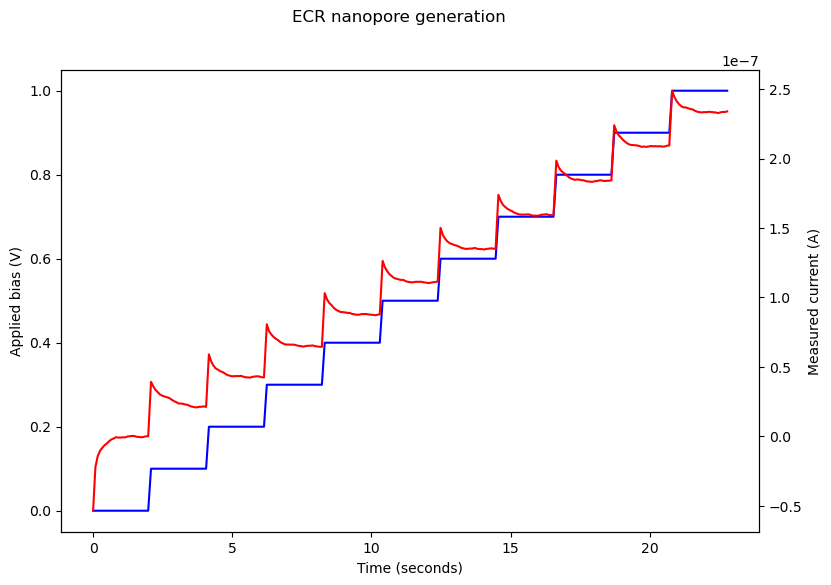

In [243]:
exp_time, exp_bias, exp_curr = [], [], []

for data in open(filename, 'r'):
    seconds = float(data.split(",")[0])
    bias = float(data.split(",")[1])
    current = float(data.split(",")[2].strip('""\n'))
    
    exp_time.append(seconds)
    exp_bias.append(bias)
    exp_curr.append(current)
    
fig, bias_ax = plt.subplots(figsize=(9,6))
curr_ax = bias_ax.twinx()
bias_ax.plot(exp_time, exp_bias, 'b')
curr_ax.plot(exp_time, exp_curr, 'r')

bias_ax.set_xlabel('Time (seconds)')
bias_ax.set_ylabel('Applied bias (V)')
curr_ax.set_ylabel('Measured current (A)')
fig.suptitle("ECR nanopore generation")    